In [1]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

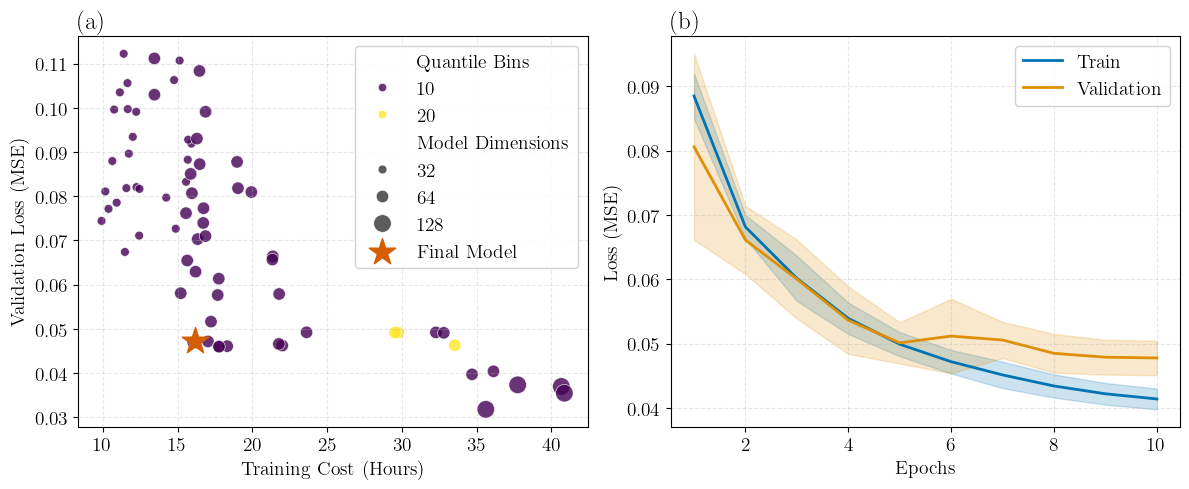

Saved: results\figures\pareto_history.pdf


In [3]:
# Paths
metrics_path = os.path.join("results", "training_metrics.csv")
history_path = os.path.join("models", "DAPINet", "training_history.json")
output_dir = os.path.join("results", "figures")
os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv(metrics_path)
df = df.dropna(subset=["Average Best Val Loss"])
df = df[df["Filename"] != "train_55180658.err"]
df = df[df["Filename"] != "train_54243433.err"]
# train_54243433.err

df["Training Loop Duration"] = pd.to_numeric(df["Training Loop Duration"], errors="coerce")
df["Average Best Val Loss"] = pd.to_numeric(df["Average Best Val Loss"], errors="coerce")
df["Duration_Hours"] = df["Training Loop Duration"] / 3600.0

with open(history_path, encoding="utf-8") as f:
    history_runs = json.load(f)

# Prepare training history arrays
train_losses = [run["train_loss"] for run in history_runs]
val_losses = [run["val_loss"] for run in history_runs]
epochs = list(range(1, len(train_losses[0]) + 1))

train_df = pd.DataFrame(train_losses)
val_df = pd.DataFrame(val_losses)
train_mean = train_df.mean(axis=0)
train_std = train_df.std(axis=0)
val_mean = val_df.mean(axis=0)
val_std = val_df.std(axis=0)

# Plot (re-apply rcParams to ensure Type 1 fonts)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

palette = sns.color_palette("colorblind", 4)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (a) Pareto plot
df_plot = df.rename(columns={"NUM_BINS": "Quantile Bins", "D_MODEL": "Model Dimensions"})
sns.scatterplot(
    data=df_plot,
    x="Duration_Hours",
    y="Average Best Val Loss",
    hue="Quantile Bins",
    palette="viridis",
    size="Model Dimensions",
    sizes=(40, 160),
    alpha=0.8,
    ax=axes[0],
)
final_model_row = df_plot[df_plot["Filename"].str.contains("train_54109677", na=False)]
if not final_model_row.empty:
    axes[0].scatter(
        final_model_row["Duration_Hours"],
        final_model_row["Average Best Val Loss"],
        color=palette[3],
        s=400,
        marker="*",
        label="Final Model",
        zorder=5,
    )
axes[0].set_title(r"(a)", loc="left")
axes[0].set_xlabel(r"Training Cost (Hours)")
axes[0].set_ylabel(r"Validation Loss (MSE)")
axes[0].legend(frameon=True, framealpha=0.9)
axes[0].grid(True, alpha=0.3, linestyle="--")

# (b) Training history
axes[1].plot(epochs, train_mean, color=palette[0], label="Train", linewidth=2)
axes[1].fill_between(
    epochs,
    train_mean - train_std,
    train_mean + train_std,
    color=palette[0],
    alpha=0.2,
)
axes[1].plot(epochs, val_mean, color=palette[1], label="Validation", linewidth=2)
axes[1].fill_between(
    epochs,
    val_mean - val_std,
    val_mean + val_std,
    color=palette[1],
    alpha=0.2,
)
axes[1].set_title(r"(b)", loc="left")
axes[1].set_xlabel(r"Epochs")
axes[1].set_ylabel(r"Loss (MSE)")
axes[1].legend(frameon=True, framealpha=0.9)
axes[1].grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
output_path = os.path.join(output_dir, "pareto_history.pdf")
plt.savefig(output_path, bbox_inches="tight", dpi=600)
plt.show()
print(f"Saved: {output_path}")